In [1]:
# --- 1. INSTALACIÓN DE LIBRERÍAS NECESARIAS ---
!pip install lxml pandas seaborn matplotlib

In [2]:
# --- 2. IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Circle
from matplotlib.colors import LinearSegmentedColormap
from collections import defaultdict
from pathlib import Path
import seaborn as sns


In [3]:
# ---------------------------
# Función para cargar datos
# ---------------------------
def cargar_datos_nacsport(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    data = []
    for instance in root.findall(".//instance"):
        jugador = instance.findtext("code")  # Origen del pase
        labels = [lbl.findtext("text") for lbl in instance.findall("label")]
        pos_x = [float(px.text) for px in instance.findall("pos_x")]
        pos_y = [float(py.text) for py in instance.findall("pos_y")]
        data.append({
            "jugador": jugador,
            "labels": labels,
            "pos_x_list": pos_x,
            "pos_y_list": pos_y
        })
    return pd.DataFrame(data)

In [4]:
# ---------------------------
# Dibujar cancha horizontal
# ---------------------------
def draw_futsal_pitch_horizontal(ax):
    ax.set_facecolor("white")
    ancho = 35
    alto = 20

    plt.plot([0, ancho], [0, 0], color="black")
    plt.plot([0, ancho], [alto, alto], color="black")
    plt.plot([0, 0], [0, alto], color="black")
    plt.plot([ancho, ancho], [0, alto], color="black")
    plt.plot([ancho / 2, ancho / 2], [0, alto], color="black")

    area_izq = Arc((0, alto / 2), width=8, height=12, angle=0,
                   theta1=270, theta2=90, color="black")
    ax.add_patch(area_izq)
    plt.plot([0, 1], [8.5, 8.5], color="black", linewidth=2)
    plt.plot([0, 1], [11.5, 11.5], color="black", linewidth=2)
    plt.plot([1, 1], [8.5, 11.5], color="black", linewidth=2)

    area_der = Arc((ancho, alto / 2), width=8, height=12, angle=0,
                   theta1=90, theta2=270, color="black")
    ax.add_patch(area_der)
    plt.plot([ancho, ancho - 1], [8.5, 8.5], color="black", linewidth=2)
    plt.plot([ancho, ancho - 1], [11.5, 11.5], color="black", linewidth=2)
    plt.plot([ancho - 1, ancho - 1], [8.5, 11.5], color="black", linewidth=2)

    centre_circle = Circle((ancho / 2, alto / 2), 4, color="black", fill=False)
    centre_spot = Circle((ancho / 2, alto / 2), 0.2, color="black")
    ax.add_patch(centre_circle)
    ax.add_patch(centre_spot)

    ax.set_xlim(0, ancho)
    ax.set_ylim(0, alto)
    ax.axis('off')


In [5]:
# ---------------------------
# Red de pases
# ---------------------------
def red_de_pases_por_rol(df):
    keywords = [
        "pase corto frontal", "pase corto lateral",
        "pase largo frontal", "pase largo lateral",
        "pase progresivo frontal", "pase progresivo lateral",
        "pase progresivo frontal cpie", "pase progresivo lateral cpie",
        "salida de arco progresivo cmano",
        "pase corto frontal cpie", "pase corto lateral cpie",
        "salida de arco corto cmano"
    ]
    keywords = [k.lower() for k in keywords]

    coords_origen = defaultdict(list)
    totales_hechos_por_rol = defaultdict(int)
    conteo_roles_total = defaultdict(int)

    for _, row in df.iterrows():
        labels_lower = [str(lbl).lower() for lbl in row['labels'] if lbl is not None]
        if not any(k in lbl for lbl in labels_lower for k in keywords):
            continue

        # Rol origen
        if "(" in row['jugador'] and ")" in row['jugador']:
            rol_origen = row['jugador'].split("(")[1].replace(")", "").strip()
        else:
            rol_origen = row['jugador'].strip()

        if rol_origen.lower().startswith("categoria") or "rival" in rol_origen.lower():
            continue

        # Rol destino: primera etiqueta con formato (Rol) distinta al origen
        rol_destino = None
        for lbl in row['labels']:
            if lbl and "(" in lbl and ")" in lbl:
                posible_destino = lbl.split("(")[1].replace(")", "").strip()
                if posible_destino != rol_origen:
                    rol_destino = posible_destino
                    break

        # Guardar coordenadas de origen para ubicar nodo
        if len(row['pos_x_list']) >= 1 and len(row['pos_y_list']) >= 1:
            x_origen = 35 - (row['pos_y_list'][0] * (35 / 40))
            y_origen = row['pos_x_list'][0]
            coords_origen[rol_origen].append((x_origen, y_origen))

        # Contador de pases hechos
        totales_hechos_por_rol[rol_origen] += 1

        # Conteo ida+vuelta
        if rol_destino and rol_destino != rol_origen:
            conteo_roles_total[tuple(sorted([rol_origen, rol_destino]))] += 1

    # Coordenadas promedio por rol
    rol_coords_promedio = {}
    for rol, coords in coords_origen.items():
        arr = np.array(coords)
        rol_coords_promedio[rol] = (arr[:, 0].mean(), arr[:, 1].mean())

    if "Arq" in rol_coords_promedio:
        rol_coords_promedio["Arq"] = (3, 10)

    # Inversión táctica de alas
    if "Ala I" in rol_coords_promedio and "Ala D" in rol_coords_promedio:
        y_ala_i = rol_coords_promedio["Ala I"][1]
        y_ala_d = rol_coords_promedio["Ala D"][1]
        if y_ala_i < y_ala_d:
            rol_coords_promedio["Ala I"], rol_coords_promedio["Ala D"] = rol_coords_promedio["Ala D"], rol_coords_promedio["Ala I"]

            nuevos_conteos = defaultdict(int)
            for (a, b), val in conteo_roles_total.items():
                roles = [a, b]
                roles_swap = []
                for r in roles:
                    if r == "Ala I":
                        roles_swap.append("Ala D")
                    elif r == "Ala D":
                        roles_swap.append("Ala I")
                    else:
                        roles_swap.append(r)
                nuevos_conteos[tuple(sorted(roles_swap))] += val
            conteo_roles_total = nuevos_conteos

            nuevos_totales = defaultdict(int)
            for rol, total in totales_hechos_por_rol.items():
                if rol == "Ala I":
                    nuevos_totales["Ala D"] = total
                elif rol == "Ala D":
                    nuevos_totales["Ala I"] = total
                else:
                    nuevos_totales[rol] = total
            totales_hechos_por_rol = nuevos_totales

    # Dibujar
    fig, ax = plt.subplots(figsize=(10, 6))
    draw_futsal_pitch_horizontal(ax)

    max_pases = max(conteo_roles_total.values()) if conteo_roles_total else 1

    # Líneas con totales ida+vuelta
    for (rol_a, rol_b), count in conteo_roles_total.items():
        if rol_a in rol_coords_promedio and rol_b in rol_coords_promedio:
            x1, y1 = rol_coords_promedio[rol_a]
            x2, y2 = rol_coords_promedio[rol_b]
            grosor = 1 + (count / max_pases) * 5
            ax.plot([x1, x2], [y1, y2], color='red', linewidth=grosor, alpha=0.7)
            xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
            ax.text(xm, ym, str(count), color='blue', fontsize=10,
                    ha='center', fontweight='bold', zorder=6)

    # Nodos con nombre + total hechos
    for rol, (x, y) in rol_coords_promedio.items():
        ax.scatter(x, y, s=2000, color='white', edgecolors='black', zorder=5)
        ax.text(x, y, f"{rol}\n{totales_hechos_por_rol[rol]}", ha='center', va='center',
                fontsize=10, fontweight='bold', color='black', zorder=7)

    plt.title("Red de Pases por Rol (Azul: total ida+vuelta, Negro: total hechos)", fontsize=14)
    plt.show()


Mounted at /content/drive/


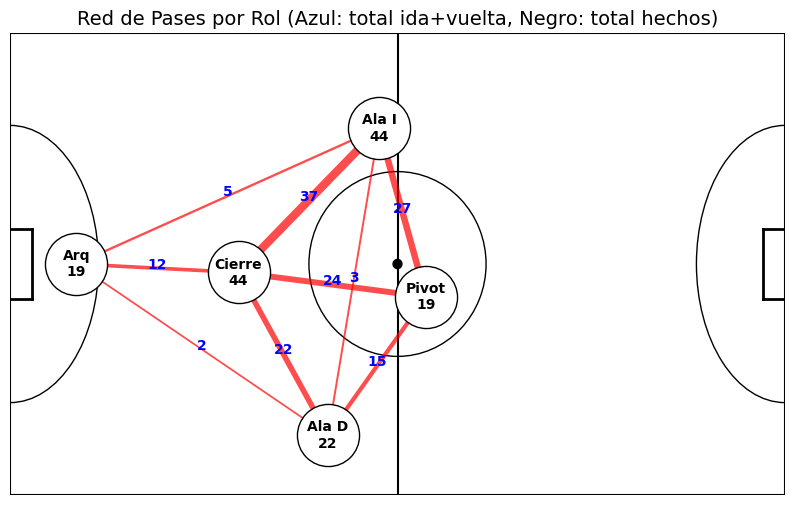

In [6]:
# ---------------------------
# Ejecutar
# ---------------------------
#Montamos el drive de Google
from google.colab import drive
drive.mount('/content/drive/')

# Ruta base donde está el archivo
ruta_base = Path('/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Jugadores')

xml_file = ruta_base / "Union Ezpeleta - XML NacSport.xml"
df = cargar_datos_nacsport(xml_file)
red_de_pases_por_rol(df)